# Carregando e visualizando dados no Google Colab

Vamos começar entendendo como um LLM (grande modelo de linguagem) pode nos auxiliar, por exemplo, gerando um código para analisar um arquivo. Iniciaremos no Google Colab carregando os dados da empresa. Para isso, importaremos a biblioteca Pandas, voltada para análise de dados, com o comando:

In [60]:
import pandas as pd
from dotenv import load_dotenv
import os
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.prompts import PromptTemplate
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.display import display, Markdown
from langchain.agents import Tool
from langchain import hub

import matplotlib.pyplot as plt
import seaborn as sns


load_dotenv()
 
GOOGLE_API_KEY = str(os.getenv("GOOGLE_API_KEY"))

In [2]:
print("Google API Key:", len(GOOGLE_API_KEY))

Google API Key: 39


In [39]:
url = 'https://raw.githubusercontent.com/Ricardo-Filgueiras/AgentesIA-com-Analise-de-dados/refs/heads/main/database/dados_entregas.csv' 

In [40]:
df = pd.read_csv(url)

In [41]:
df.tail(n=3)

,ID_pedido,anos_experiencia_agente,classificacao_agente,latitude_loja,longitude_loja,latitude_entrega,longitude_entrega,data_pedido,hora_pedido,hora_retirada,clima,trafego,veiculo,area,categoria_produto,tempo_entrega
43736,xnek760674819,12,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,Nublado,Baixo,Scooter,Metropolitano,Casa,80
43737,cynl434665991,17,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,Nublado,Alto,Motocicleta,Metropolitano,Cozinha,130
43738,nsyz997960170,16,4.9,23.351058,85.325731,23.431058,85.405731,2022-03-02,17:10:00,17:15:00,Neblina,Medio,Scooter,Metropolitano,Cosmeticos,180


# Automatizando a análise de dados com LLMs

O objetivo é que a equipe de dados, ao receber esse arquivo, possa construir um modelo preditivo para prever o tempo de entrega com base nas características disponíveis. Para isso, é necessário analisar os dados, verificar os tipos de cada coluna, tratar dados nulos e duplicados, e explorar relações, como a influência dos anos de experiência no tempo de entrega.

Queremos automatizar esse processo, evitando a necessidade de escrever código manualmente para calcular correlações, por exemplo. Desejamos que um LLM gere o código necessário para automatizar essas tarefas. Vamos aprender a obter esse código utilizando a ferramenta LangChain, que está em alta no campo da inteligência artificial e é útil para criar soluções e aplicações.

Configurando o LangChain e o Gemini

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI



llm = ChatGoogleGenerativeAI(
     model="gemini-2.0-flash",
     temperature=0,
     max_tokens=None,
     timeout=None,
     max_retries=2,
     
    )

## Executando o código gerado com ferramentas Python

primeiramente vamos instalar mais uma ferramenta !

Para automatizar o processo de execução de código gerado por um LLM, utilizamos o LangChain, especificamente a ferramenta python-est-repltool. Vamos começar instalando o pacote experimental do LangChain, onde essa ferramenta está localizada. Para isso, executamos o seguinte comando

In [7]:
from langchain_experimental.tools import PythonAstREPLTool

Configurando a ferramenta PythonAstREPLTool

In [8]:
ferramenta_python = PythonAstREPLTool(locals={"df": df})

### Integrando a ferramenta com um LLM

In [9]:
llm_com_ferramenta = llm.bind_tools([ferramenta_python], tool_choice=ferramenta_python.name)

## Criando o prompt com template

Para orientar o modelo, vamos criar um prompt usando um template. No LangChain, temos algumas opções, como o ChatPromptTemplate, que serve para criar um prompt de conversação. Imagine que haverá uma conversa em que a pessoa envia uma mensagem, a inteligência artificial gera o código, e esse código é executado pela nossa ferramenta Python. Todo esse processo ocorre de forma integrada.

## Configurando o agente executor
Agora, vamos criar uma variável chamada agente_executor para armazenar o agente que vamos executar. Atribuímos a essa variável a função que acabamos de importar e passamos alguns parâmetros necessários:

## Primeiro Agent

In [10]:
agente_executor = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    agent_type="tool-calling",
    verbose=True,
    allow_dangerous_code=True
)

In [11]:
agente_executor.invoke({"input": """Qual é a correlação entre anos de experiência do agente e tempo de entrega?
E maior que a correlação entre classificacao do agente e tempo de entrega?
"""})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "correlation_experience_delivery = df['anos_experiencia_agente'].corr(df['tempo_entrega'])\ncorrelation_rating_delivery = df['classificacao_agente'].corr(df['tempo_entrega'])\nprint(f'{correlation_experience_delivery=}')\nprint(f'{correlation_rating_delivery=}')"}`
responded: Para responder a essa pergunta, preciso calcular a correlação entre 'anos_experiencia_agente' e 'tempo_entrega', e a correlação entre 'classificacao_agente' e 'tempo_entrega'. Depois, compararei os valores absolutos dessas correlações.



correlation_experience_delivery=np.float64(-0.2516410755060903)
correlation_rating_delivery=np.float64(-0.291975378761101)

Invoking: `python_repl_ast` with `{'query': "correlation_experience_delivery = df['anos_experiencia_agente'].corr(df['tempo_entrega'])\nprint(correlation_experience_delivery)"}`


-0.2516410755060903
A correlação entre anos de experiência do agente e tempo de entrega é de -0

{'input': 'Qual é a correlação entre anos de experiência do agente e tempo de entrega?\nE maior que a correlação entre classificacao do agente e tempo de entrega?\n',
 'output': 'A correlação entre anos de experiência do agente e tempo de entrega é de -0.2516. A correlação entre classificação do agente e tempo de entrega é de -0.2920. Portanto, a correlação entre anos de experiência do agente e tempo de entrega não é maior que a correlação entre classificação do agente e tempo de entrega.'}

In [12]:
agente_executor.invoke({"input": """Qual é a média do tempo de entrega para cada categoria de produto?
Qual é a categoria com menor média?
"""})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\n\ndf_grouped = df.groupby('categoria_produto')['tempo_entrega'].mean()\nprint(df_grouped)\nprint(df_grouped.idxmin())"}`


categoria_produto
Acessorios           132.048789
Brinquedos           129.395901
Calçados             131.151538
Casa                 130.955307
Cosmeticos           132.902503
Cozinha              132.326973
Cuidados pessoais    132.027417
Eletronicos          130.837136
Esportes             132.247150
Joias                130.753034
Lanches              131.904332
Lazer                131.059337
Livros               131.021601
Mercado               26.539576
Pets                 131.291822
Roupas               130.483690
Name: tempo_entrega, dtype: float64
Mercado
A categoria com a menor média de tempo de entrega é "Mercado".

> Finished chain.


{'input': 'Qual é a média do tempo de entrega para cada categoria de produto?\nQual é a categoria com menor média?\n',
 'output': 'A categoria com a menor média de tempo de entrega é "Mercado".'}

## Construindo Ferramentas do Zero

In [13]:
from langchain.tools import tool

### Ferramenta exploradora
Descrição:

Utilize esta ferramenta sempre que o usuário solicitar informações gerais sobre o DataFrame, incluindo número de colunas e linhas, nomes das colunas e seus tipos de dados, contagem de dados nulos e duplicados para dar um panorama geral sobre o arquivo.

Você é um analista de dados encarregado de apresentar um resumo informativo sobre um     DataFrame a partir de uma {pergunta} feita pelo usuário.

        A seguir, você encontrará as informações gerais da base de dados:

        ================= INFORMAÇÕES DO DATAFRAME =================

        Dimensões: {shape}

        Colunas e tipos de dados:
        {columns}

        Valores nulos por coluna:
        {nulos}

        Strings 'nan' (qualquer capitalização) por coluna:
        {nans_str}

        Linhas duplicadas: {duplicados}

        ============================================================

        Com base nessas informações, escreva um resumo claro e organizado contendo:
        1. Um título: ## Relatório de informações gerais sobre o dataset,
        2. A dimensão total do DataFrame;
        3. A descrição de cada coluna (incluindo nome, tipo de dado e o que aquela coluna é),
        4. As colunas que contêm dados nulos, com a respectiva quantidade;
        5. As colunas que contêm strings 'nan', com a respectiva quantidade;
        6. E a existência (ou não) de dados duplicados;
        7. Escreva um parágrafo sobre análises que podem ser feitas com
        esses dados;
        8. Escreva um parágrafo sobre tratamentos que podem ser feitos nos dados.

In [18]:
@tool
def informacoes_dataframe(pergunta: str) -> str :
    """Utilize esta ferramenta sempre que o usuário solicitar informações gerais sobre o DataFrame,
    incluindo número de colunas e linhas, nomes das colunas e seus tipos de dados, contagem de dados nulos
    e duplicados para dar um panorama geral sobre o arquivo."""

    shape = df.shape

    columns = df.dtypes

    nulos = df.isnull().sum()
    
    nans_str = df.apply(lambda col: col[~col.isna()].astype(str).str.strip().str.lower().eq('nan')).sum()

    duplicados = df.duplicated().sum()

    template_resposta = PromptTemplate(
        template = """
            Você é um analista de dados encarregado de apresentar um resumo informativo sobre um DataFrame a partir de uma {pergunta} feita pelo usuário.

            A seguir, você encontrará as informações gerais da base de dados:
            ==================== INFORMAÇÕES DO DATAFRAME ====================
            Dimensões: {shape}

            Colunas e tipos de dados: {columns}

            Valores nulos por coluna: {nulos}

            Strings 'nan' (qualquer capitalização) por coluna: {nans_str}

            Linhas duplicadas: {duplicados}
            ==================================================================

            Com base nessas informações, escreva um resumo claro e organizado contendo:
            1. Um título: ## Relatório de Informações gerais sobre o dataset,
            2. A dimensão total do DataFrame,
            3. A descrição de cada coluna (incluindo nome, tipo de dado e o que aquela coluna é),
            4. As colunas que contém dados nulos, com a respectiva quantidade;
            5. As colunas que contém strings 'nan', com a respectiva quantidade;
            6. E a existência (ou não) de dados duplicados;
            7. Escreva um parágrafo sobre analises que podem ser feitas com esses dados;
            8. Escreva um parágrafo sobre tratamentos que podem ser feitos nos dados.
        """,
                input_variables=['pergunta', 'shape', 'columns', 'nulos', 'nans_str', 'duplicados']
            )

    cadeia = template_resposta | llm | StrOutputParser()
    resposta = cadeia.invoke({
        'pergunta': pergunta,
        'shape': shape,
        'columns': columns,
        'nulos': nulos,
        'nans_str': nans_str,
        'duplicados': duplicados
    })
    return resposta

In [ ]:
relatorio_informacoes = informacoes_dataframe.invoke("quais as informaçoes gerais sobre o dataframe?")
print(relatorio_informacoes)

In [21]:
display(Markdown(relatorio_informacoes))

## Relatório de Informações Gerais sobre o Dataset

Este relatório apresenta um resumo das informações gerais do DataFrame fornecido, visando fornecer uma visão clara da estrutura e qualidade dos dados.

**1. Dimensão do DataFrame:**

O DataFrame possui 43.739 linhas e 16 colunas.

**2. Descrição das Colunas:**

*   **ID\_pedido:** (object) Identificador único de cada pedido.
*   **anos\_experiencia\_agente:** (int64) Anos de experiência do agente de entrega.
*   **classificacao\_agente:** (float64) Classificação do agente de entrega.
*   **latitude\_loja:** (float64) Latitude da localização da loja.
*   **longitude\_loja:** (float64) Longitude da localização da loja.
*   **latitude\_entrega:** (float64) Latitude do local de entrega.
*   **longitude\_entrega:** (float64) Longitude do local de entrega.
*   **data\_pedido:** (object) Data em que o pedido foi realizado.
*   **hora\_pedido:** (object) Hora em que o pedido foi realizado.
*   **hora\_retirada:** (object) Hora em que o pedido foi retirado para entrega.
*   **clima:** (object) Condição climática no momento da entrega.
*   **trafego:** (object) Nível de tráfego no momento da entrega.
*   **veiculo:** (object) Tipo de veículo utilizado na entrega.
*   **area:** (object) Área geográfica da entrega.
*   **categoria\_produto:** (object) Categoria do produto entregue.
*   **tempo\_entrega:** (int64) Tempo total de entrega em minutos.

**3. Colunas com Dados Nulos:**

*   **classificacao\_agente:** 54 valores nulos.
*   **clima:** 91 valores nulos.
*   **trafego:** 91 valores nulos.

**4. Colunas com Strings 'nan':**

*   **hora\_pedido:** 91 strings 'nan'.

**5. Dados Duplicados:**

Não há linhas duplicadas no DataFrame.

**6. Análises Possíveis:**

Com base nesses dados, diversas análises podem ser realizadas. É possível analisar a relação entre os anos de experiência do agente e sua classificação, identificar áreas com maior demanda de entrega, verificar a influência do clima e do tráfego no tempo de entrega, e analisar quais categorias de produtos são mais populares em diferentes áreas. Além disso, pode-se investigar a eficiência dos diferentes tipos de veículos utilizados nas entregas.

**7. Tratamentos Recomendados:**

Recomenda-se tratar os valores nulos nas colunas "classificacao\_agente", "clima" e "trafego". A imputação de valores (utilizando a média, mediana ou moda) ou a remoção das linhas com valores nulos são opções a serem consideradas, dependendo do impacto na análise. As strings 'nan' na coluna "hora\_pedido" também devem ser tratadas, seja convertendo-as para valores nulos e aplicando uma estratégia de imputação, ou removendo as linhas correspondentes.

### Ferramenta estatística
Descrição:

Utilize esta ferramenta sempre que o usuário solicitar um resumo estatístico completo e descritivo da base de dados, incluindo várias estatísticas (média, desvio padrão, mínimo, máximo etc.)

Prompt:

Você é um analista de dados encarregado de interpretar resultados estatísticos de uma base de dados a partir de uma {pergunta} feita pelo usuário.

        A seguir, você encontrará as estatísticas descritivas da base de dados:

        ================= ESTATÍSTICAS DESCRITIVAS =================

        {resumo}

        ============================================================

Com base nesses dados, elabore um resumo explicativo com linguagem clara, acessível e fluida, destacando os principais pontos dos resultados. Inclua:

        1. Um título: ## Relatório de estatísticas descritivas;
        2. Uma visão geral das estatísticas das colunas numéricas;
        3. Um parágrafo sobre cada uma das colunas, comentando informações sobre seus valores;
        4. Identificação de possíveis outliers com base nos valores mínimo e máximo;
        5. Recomendações de próximos passos na análise com base nos padrões identificados.

In [95]:
@tool
def resumo_estatistico(pergunta: str) -> str:
    """Utilize esta ferramenta sempre que o usuário solicitar um resumo estatístico do DataFrame,
    incluindo (média, mediana, desvio padrão, valores máximos e mínimos, contagem de valores únicos
    e frequências dos valores mais comuns)"""

    estatisticas_descritivas = df.describe(include="number").transpose().to_string()

    template_resposta = PromptTemplate(
        template = """
            Você é um analista de dados encarregado de apresentar um resumo estatístico sobre um DataFrame a partir de uma {pergunta} feita pelo usuário.

            A seguir, você encontrará as informações gerais da base de dados:
            ==================== INFORMAÇÕES DO DATAFRAME ====================
            {resumo}
            ==================================================================
            Com base nesses dados, elabore um resumo explicativo com linguagem clara, acessível e fluída, destacando
            os principais pontos dos resultados. Inclua:
            1. Um título: ## Relatório de estatísticas descritivas;
            2. Uma visão geral das estatísticas das colunas numéricas;
            3. Um parágrafo sobre cada uma das colunas, comentando informações sobre seus valores;
            4. Identificação de possíveis outliers com base nos valores mínimo e máximo;
            5. Recomendações de próximos passos na análise com base nos padrões identificados.
            6. Se houver uma pergunta específica do usuário, responda-a de forma clara e objetiva.
        """,
                input_variables=['pergunta', 'resumo']
            )

    cadeia = template_resposta | llm | StrOutputParser()
    resposta = cadeia.invoke({
        'pergunta': pergunta,
        'resumo': estatisticas_descritivas
    })
    return resposta

In [ ]:
relatorio_estatistico = resumo_esttatistico.invoke("quais as estatisticas descritivas dos dados?")
#print(relatorio_estatistico) "quais as informaçoes gerais sobre o dataframe?"

In [28]:
display(Markdown(relatorio_estatistico))

## Relatório de Estatísticas Descritivas

Este relatório apresenta um resumo das estatísticas descritivas de um conjunto de dados, fornecendo insights sobre a distribuição e características das variáveis numéricas presentes. A análise abrange informações como média, desvio padrão, valores mínimo e máximo, além dos quartis (25%, 50% e 75%).

**Visão Geral das Estatísticas**

O conjunto de dados é composto por 43.739 observações, com exceção da coluna 'classificacao_agente' que possui 43.685, indicando a presença de valores ausentes. As variáveis analisadas incluem anos de experiência dos agentes, classificação dos agentes, latitude e longitude das lojas e entregas, e o tempo de entrega.

**Análise Detalhada por Coluna**

*   **anos\_experiencia\_agente:** A experiência média dos agentes é de aproximadamente 12 anos, com um desvio padrão de 3.11 anos. A experiência varia de 1 a 20 anos, indicando uma boa diversidade na experiência dos agentes.
*   **classificacao\_agente:** A classificação média dos agentes é de 4.63, em uma escala que varia de 1 a 5. A proximidade entre a média e o valor máximo (5) sugere uma tendência de classificações elevadas.
*   **latitude\_loja:** A latitude das lojas varia de -30.90 a 30.91, com uma média de 17.21 e desvio padrão de 7.76. Essa variação indica que as lojas estão distribuídas em diferentes localizações geográficas.
*   **longitude\_loja:** A longitude das lojas varia de -88.37 a 88.43, com uma média de 70.66 e desvio padrão de 21.48. Assim como a latitude, a longitude apresenta uma variação considerável, refletindo a dispersão geográfica das lojas.
*   **latitude\_entrega:** A latitude dos locais de entrega varia de 0.01 a 31.05, com uma média de 17.46 e desvio padrão de 7.34. A amplitude dos dados sugere uma cobertura de entrega em diversas áreas.
*   **longitude\_entrega:** A longitude dos locais de entrega varia de 0.01 a 88.56, com uma média de 70.82 e desvio padrão de 21.15. Similar à latitude de entrega, a longitude também demonstra uma ampla área de cobertura.
*   **tempo\_entrega:** O tempo médio de entrega é de 124.91 minutos, com um desvio padrão de 51.92 minutos. O tempo de entrega varia de 10 a 270 minutos, indicando uma considerável variação no tempo necessário para realizar as entregas.

**Identificação de Possíveis Outliers**

Com base nos valores mínimo e máximo, algumas colunas podem conter outliers:

*   **latitude\_entrega e longitude\_entrega:** A presença de valores próximos a zero pode indicar erros de digitação ou localizações inválidas.
*   **tempo\_entrega:** O valor máximo de 270 minutos (4,5 horas) pode ser considerado um outlier, dependendo do contexto e da política de entrega da empresa.

**Recomendações para Próximos Passos**

Com base nos padrões identificados, recomenda-se:

1.  **Tratamento de valores ausentes:** Investigar e tratar os valores ausentes na coluna 'classificacao\_agente' para evitar vieses na análise.
2.  **Análise de outliers:** Investigar os possíveis outliers nas colunas 'latitude\_entrega', 'longitude\_entrega' e 'tempo\_entrega' para determinar se são erros ou representam situações atípicas que merecem atenção.
3.  **Análise de correlação:** Avaliar a correlação entre as variáveis para identificar possíveis relações entre elas. Por exemplo, verificar se existe correlação entre anos de experiência do agente e a classificação do agente, ou entre a localização da loja e o tempo de entrega.
4.  **Segmentação:** Segmentar os dados com base em diferentes critérios (por exemplo, localização da loja, tempo de entrega) para identificar padrões específicos em cada segmento.
5.  **Visualização de dados:** Utilizar gráficos e visualizações para explorar a distribuição das variáveis e identificar padrões visuais que podem não ser evidentes nas estatísticas descritivas.
6.  **Análise de séries temporais:** Se os dados forem coletados ao longo do tempo, realizar uma análise de séries temporais para identificar tendências e sazonalidades no tempo de entrega e outras variáveis relevantes.

In [ ]:
display(Markdown(relatorio_estatistico)) #"quais as informaçoes gerais sobre o dataframe?"

## Relatório de Estatísticas Descritivas

Este relatório apresenta um resumo das estatísticas descritivas das colunas numéricas do nosso DataFrame. O objetivo é fornecer uma visão geral dos dados, identificar padrões e anomalias, e sugerir próximos passos para uma análise mais aprofundada.

**Visão Geral das Estatísticas**

A tabela abaixo resume as principais estatísticas de cada coluna numérica: contagem, média, desvio padrão, valor mínimo, quartis (25%, 50%, 75%) e valor máximo.

|                               | count   | mean      | std       | min       | 25%       | 50%       | 75%       | max       |
| :---------------------------- | :------ | :---------- | :---------- | :-------- | :-------- | :-------- | :-------- | :-------- |
| anos_experiencia_agente       | 43739   | 12.114292 | 3.112121  | 1.000000  | 9.000000  | 12.000000 | 15.000000 | 20.000000 |
| classificacao_agente          | 43685   | 4.632567  | 0.331560  | 1.000000  | 4.500000  | 4.700000  | 4.900000  | 5.000000  |
| latitude_loja                 | 43739   | 17.210960 | 7.764225  | -30.902872 | 12.933298 | 18.551440 | 22.732225 | 30.914057 |
| longitude_loja                | 43739   | 70.661177 | 21.475005 | -88.366217 | 73.170283 | 75.898497 | 78.045359 | 88.433452 |
| latitude_entrega              | 43739   | 17.459031 | 7.342950  | 0.010000  | 12.985996 | 18.633626 | 22.785049 | 31.054057 |
| longitude_entrega             | 43739   | 70.821842 | 21.153148 | 0.010000  | 73.280000 | 76.002574 | 78.104095 | 88.563452 |
| tempo_entrega                 | 43739   | 124.905645 | 51.915451 | 10.000000 | 90.000000 | 125.000000 | 160.000000 | 270.000000 |

**Análise por Coluna**

*   **anos\_experiencia\_agente:** A experiência média dos agentes é de aproximadamente 12 anos, com uma variação relativamente pequena (desvio padrão de 3.11 anos). A experiência varia de 1 a 20 anos.

*   **classificacao\_agente:** A classificação média dos agentes é de 4.63, numa escala que vai de 1 a 5. O desvio padrão é baixo (0.33), indicando que a maioria dos agentes tem classificações próximas à média. Há alguns valores faltantes nesta coluna.

*   **latitude\_loja:** A latitude média das lojas é de 17.21, com uma variação considerável (desvio padrão de 7.76). Os valores variam de -30.90 a 30.91. A amplitude dos valores sugere que as lojas estão distribuídas em uma área geográfica extensa.

*   **longitude\_loja:** A longitude média das lojas é de 70.66, com uma variação considerável (desvio padrão de 21.48). Os valores variam de -88.37 a 88.43. Assim como a latitude, a amplitude dos valores sugere uma distribuição geográfica extensa das lojas.

*   **latitude\_entrega:** A latitude média das entregas é de 17.46, com uma variação considerável (desvio padrão de 7.34). Os valores variam de 0.01 a 31.05.

*   **longitude\_entrega:** A longitude média das entregas é de 70.82, com uma variação considerável (desvio padrão de 21.15). Os valores variam de 0.01 a 88.56.

*   **tempo\_entrega:** O tempo médio de entrega é de aproximadamente 125 minutos, com uma variação considerável (desvio padrão de 51.92 minutos). Os tempos de entrega variam de 10 a 270 minutos.

**Identificação de Possíveis Outliers**

Com base nos valores mínimos e máximos, podemos identificar alguns possíveis outliers:

*   **latitude\_loja e longitude\_loja:** Os valores mínimos negativos podem indicar erros de digitação ou lojas localizadas em regiões inesperadas.
*   **latitude\_entrega e longitude\_entrega:** Valores próximos de zero podem indicar erros de digitação ou entregas em locais inesperados.
*   **tempo\_entrega:** O tempo máximo de 270 minutos pode ser considerado um outlier, dependendo do contexto do negócio.

**Recomendações de Próximos Passos**

Com base nos padrões identificados, sugiro os seguintes próximos passos:

1.  **Tratar valores faltantes:** Investigar e tratar os valores faltantes na coluna "classificacao\_agente".
2.  **Investigar outliers:** Investigar os possíveis outliers nas colunas de latitude e longitude das lojas e entregas, bem como no tempo de entrega. Verificar se são erros de digitação ou se representam situações reais que precisam ser consideradas.
3.  **Análise de distribuição:** Analisar a distribuição das colunas numéricas usando histogramas e boxplots para identificar padrões e assimetrias.
4.  **Análise de correlação:** Calcular a matriz de correlação entre as colunas numéricas para identificar relações entre as variáveis.
5.  **Análise geográfica:** Visualizar as localizações das lojas e entregas em um mapa para entender a distribuição geográfica dos dados.
6.  **Análise de tempo de entrega:** Investigar os fatores que influenciam o tempo de entrega, como a localização da loja, a localização da entrega, a experiência do agente e a classificação do agente.

Ao seguir esses passos, será possível obter uma compreensão mais profunda dos dados e identificar oportunidades de melhoria no processo de entrega.

### Ferramenta visual
Descrição:

Utilize esta ferramenta sempre que o usuário solicitar um gráfico a partir de um DataFrame pandas (df) com base em uma instrução do usuário. A instrução pode conter pedidos como: 'Crie um gráfico da média de tempo de entrega por clima', 'Plote a distribuição do tempo de entrega' ou 'Plote a relação entre a classificação dos agentes e o tempo de entrega'. Palavras-chave comuns que indicam o uso desta ferramenta incluem: 'crie um gráfico', 'plote', 'visualize', 'faça um gráfico de', 'mostre a distribuição', 'represente graficamente', entre outros.

Prompt:

Você é um especialista em visualização de dados. Sua tarefa é gerar **apenas o código Python** para plotar um gráfico com base na solicitação do usuário.

            ## Solicitação do usuário:
            "{pergunta}"

            ## Metadados do DataFrame:
            {colunas}

            ## Amostra dos dados (3 primeiras linhas):
            {amostra}

            ## Instruções obrigatórias:
            1. Use as bibliotecas `matplotlib.pyplot` (como `plt`) e `seaborn` (como `sns`);
            2. Defina o tema com `sns.set_theme()`;
            3. Certifique-se de que todas as colunas mencionadas na solicitação existem no DataFrame chamado `df`;
            4. Escolha o tipo de gráfico adequado conforme a análise solicitada:
            - **Distribuição de variáveis numéricas**: `histplot`, `kdeplot`, `boxplot` ou `violinplot`
            - **Distribuição de variáveis categóricas**: `countplot`
            - **Comparação entre categorias**: `barplot`
            - **Relação entre variáveis**: `scatterplot`
            - **Séries temporais**: `lineplot`, com o eixo X formatado como datas
            5. Configure o tamanho do gráfico com `figsize=(8, 4)`;
            6. Adicione título e rótulos (`labels`) apropriados aos eixos;
            7. Posicione o título à esquerda com `loc='left'`, deixe o `pad=20` e use `fontsize=14`;
            8. Mantenha os ticks eixo X sem rotação com `plt.xticks(rotation=0)`;
            9. Remova as bordas superior e direita do gráfico com `sns.despine()`;
            10. Finalize o código com `plt.show()`.

            Retorne APENAS o código Python, sem nenhum texto adicional ou explicação.

            Código Python:

In [51]:
@tool
def gerar_grafico(pergunta: str) -> str:
    """Utilize esta ferramenta sempre que a pessoa usuária solicitar um gráfico a partir de um DataFrame PandasDef, 
    com base em uma instrução do usuário. A instrução pode conter pedidos como: crie um gráfico de média de tempo de 
    entrega por clima, plote a distribuição do tempo de entrega, ou plote a relação entre a classificação dos agentes 
    e o tempo de entrega. Palavras-chave comuns que indicam o uso dessa ferramenta incluem: crie um gráfico, plote, 
    visualize, faça um gráfico de, mostre a distribuição, represente graficamente, entre outros."""

    colunas_info = "\n".join([f"- {col} ({dtype})" for col, dtype in df.dtypes.items()])
    amostra_dados = df.head(10).to_dict(orient='records')

    template_resposta = PromptTemplate(
        template = """
        Você é um especialista em visualização de dados. Sua tarefa é gerar *apenas o código Python**
        para plotar um gráfico com base na solicitação do usuário.

        ## Solicitação do usuário:
        "{pergunta}"

        ## Metadados do DataFrame:
        {colunas}

        ## Amostra dos dados (3 primeiras linhas):
        {amostra}

        ## Instruções obrigatórias:
        1. Use as bibliotecas `matplotlib.pyplot` (como `plt`) e `seaborn` (como `sns`);
        2. Defina o tema com `sns.set_theme()`;
        3. Certifique-se de que todas as colunas mencionadas na solicitação existem no DataFrame chamado `df`;
        4. Escolha o tipo de gráfico adequado conforme a análise solicitada:
            - **Distribuição de variáveis numéricas**: `histplot`, `kdeplot`, `boxplot` ou `violinplot`
            - **Distribuição de variáveis categóricas**: `countplot`
            - **Comparação entre categorias**: `barplot`
            - **Relação entre variáveis**: `scatterplot` ou `lineplot`
            - **Séries temporais**: `lineplot`, com o eixo X formatado como datas
        5. Configure o tamanho do gráfico com `figsize=(8,4)`;
        6. Adicione título e rótulos (`labels`) apropriados aos eixos;
        7. Posicione o título à esquerda com `loc='left'`, deixe o `pad=20` e use `fontsize=14`;
        8. Mantenha os ticks eixo X sem rotação com `plt.xticks(rotation=0)`;
        9. Remova as bordas superior e direita do gráfico com `sns.despine()`;
        10. Finalize o código com `plt.show()`.

        Retorne APENAS o código Python, sem nenhum texto adicional ou explicação.

        Código Python:```
        """,
        input_variables=["pergunta", "colunas", "amostra"]
    )

    cadeia = template_resposta | llm | StrOutputParser()

    codigo_bruto = cadeia.invoke({
        'pergunta': pergunta,
        'colunas': colunas_info,
        'amostra': amostra_dados
    })

    # Limpa o código para remover espaços desnecessários
    codigo_limpo = codigo_bruto.replace("```python", "").replace("```", "").strip()

    # Executa o código gerado
    exec_globals = {"df": df, "plt": plt, "sns": sns}
    exec_locals = {}
    exec(codigo_limpo, exec_globals, exec_locals)
    fig = plt.gcf()
    return fig

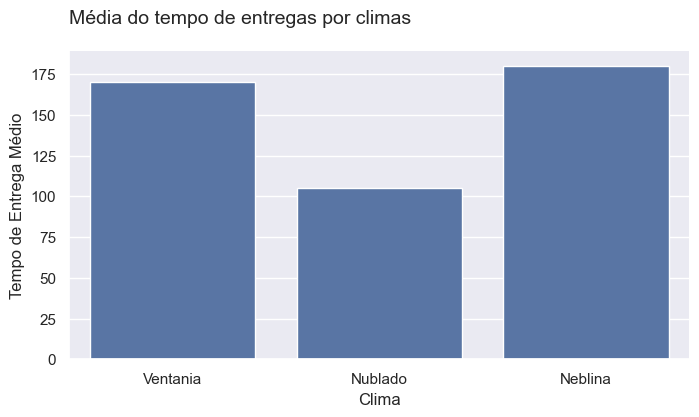

Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [36]:
resposta_grafico = gerar_grafico.invoke("Crie um gráfico da média do tempo de entregas por climas.")
print(resposta_grafico)

<string>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



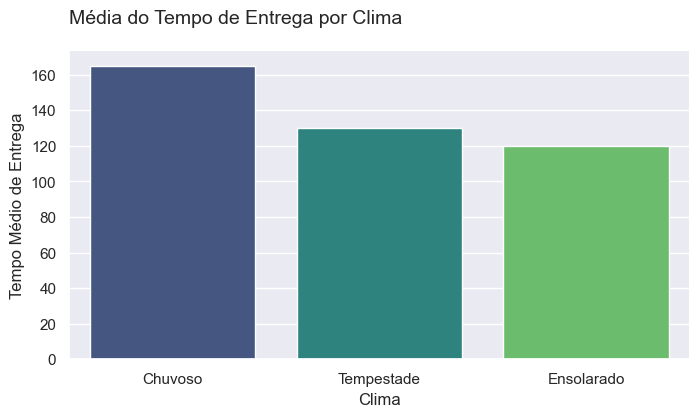

Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [44]:
resposta_grafico_1 = gerar_grafico.invoke("""Crie um gráfico da média do tempo de entrega por clima.
                                            Ordene do maior para o menor valor.""")
print(resposta_grafico_1)

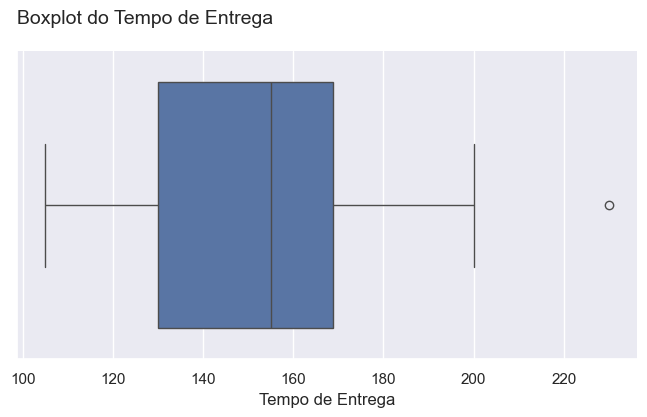

<Figure size 640x480 with 0 Axes>

In [52]:
resposta_grafico_2 = gerar_grafico.invoke("""Plote um boxplot do tempo de entrega.""")


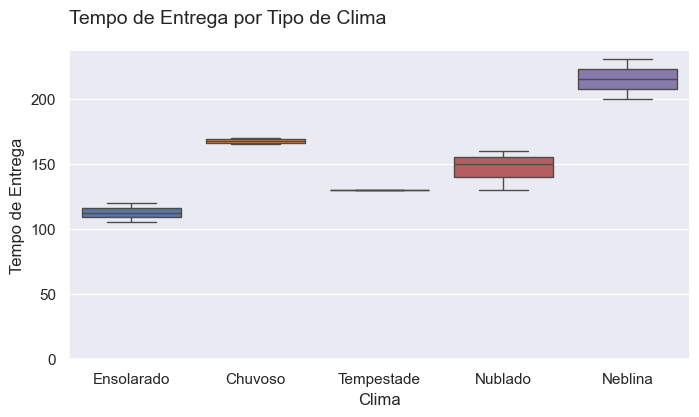

Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [56]:
resposta_grafico_4 = gerar_grafico.invoke("""Plote um boxplot do tempo de entrega para cada tipo de clima.
                                                Adicione uma hue de cores categórica. lembre-se que a base do eixo x dever ser 0 """)
print(resposta_grafico_4)

## Orquestrandos agentes capazes de Usar Ferramentas


Vamos começar a criar nosso agente. Chegamos ao momento em que conseguimos desenvolver todas as ferramentas desejadas: a ferramenta para gerar relatórios de informações, a ferramenta de análise estatística e a ferramenta que gera gráficos. Mas como podemos integrar tudo isso em um agente

In [59]:
ferramenta_informacoes_dataFrame = Tool(
    name="Informações DataFrame",
    func= informacoes_dataframe,
    description="""Utilize esta ferramenta sempre que o usuário solicitar informações gerais sobre o dataframe,
                    incluindo número de colunas e linhas, nomes das colunas e seus tipos de dados, contagem de dados nulos e
                    duplicados para dar um panorama geral sobre o arquivo.""",
    return_direct=True
)
ferramenta_resumo_estatistico = Tool(
    name="Resumo Estatístico",
    func=resumo_estatistico,
    description="""Utilize esta ferramenta sempre que o usuário solicitar um resumo estatístico completo
                    e descritivo da base de dados, incluindo várias estatísticas (média, desvio padrão, mínimo, máximo etc.).
                    Não utilize esta ferramenta para calcular uma única métrica como 'qual é a média de X' ou 
                    qual a correlação das variáveis'. Nesses casos, utilize a ferramenta_codigos_python.""",
    return_direct=True
) 
ferramenta_gerar_grafico = Tool(
    name="Gerar Gráfico",
    func=gerar_grafico,
    description="""Utilize esta ferramenta sempre que o usuário solicitar um gráfico a partir de um DataFrame
                    pandas ('df') com base em uma instrução do usuário. A instrução pode conter pedidos como: 'Crie um gráfico
                    da média de tempo de entrega por clima', 'Plote a distribuição do tempo de entrega' ou 'Plote a relação
                    entre a classificação dos agentes e o tempo de entrega'. Palavras-chave comuns que indicam o uso desta
                    ferramenta incluem: 'crie um gráfico', 'plote', 'visualize', 'faça um gráfico de', 'mostre a distribuição',
                    'represente graficamente', entre outros.""",
    return_direct=True
)
ferramenta_codigos_python = Tool(
    name="Códigos Python",
    func=PythonAstREPLTool(locals={"df": df}),
    description="""Utilize esta ferramenta sempre que o usuário solicitar cálculos, consultas ou transformações
                    específicas usando Python diretamente sobre o DataFrame `df`.
                    Exemplos de uso incluem: "Qual é a média da coluna X?", "Quais são os valores únicos da coluna Y?",
                    "Qual a correlação entre A e B?". Evite utilizar esta ferramenta para solicitações mais amplas ou descritivas,
                    como informações gerais sobre o DataFrame, resumos estatísticos completos ou geração de gráficos - nesses casos,
                    use as ferramentas apropriadas.""",
)
        

In [ ]:
prompt_react = hub.pull("hwchase17/react")

c:\Users\Campeao Lub\OneDrive - Campeão Distribuição e Logística Ltda\Documentos\GitHub\AgentesIA-com-Analise-de-dados\venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [87]:
df_head = df.head().to_markdown()

In [88]:

prompt_react_pt = PromptTemplate(
    
    input_variables=["input", "tools", "agent_scratchpad","tool_names"],
     partial_variables={"df_head": df_head},
    template =  """Você é um assistente que sempre responde em português.

                Você tem acesso a um dataframe pandas chamado `df`.
                Aqui estão as primeiras linhas do DataFrame, obtidas com `df.head().to_markdown()`:

                {df_head}

                Responda às seguintes perguntas da melhor forma possível.

                Para isso, você tem acesso às seguintes ferramentas:

                {tools}

                Use o seguinte formato:

                Question: a pergunta de entrada que você deve responder
                Thought: você deve sempre pensar no que fazer
                Action: a ação a ser tomada, deve ser uma das [{tool_names}]
                Action Input: a entrada para a ação
                Observation: o resultado da ação
                ... (este Thought/Action/Action Input/Observation pode se repetir N vezes)
                Thought: Agora eu sei a resposta final
                Final Answer: a resposta final para a pergunta de entrada original.

                Comece!

                Question: {input}
                Thought: {agent_scratchpad}"""
    )
                

In [89]:
from langchain.agents import create_react_agent
from langchain.agents import AgentExecutor

In [90]:
  
tools=[
        ferramenta_informacoes_dataFrame,
        ferramenta_resumo_estatistico,
        ferramenta_gerar_grafico,
        ferramenta_codigos_python
    ]

In [91]:
agente = create_react_agent(
    llm=llm,
    prompt=prompt_react_pt,
    tools=tools)

In [92]:
orquestrador = AgentExecutor(agent=agente, tools=tools, verbose=True, handle_parsing_errors=True)

In [93]:
resposta = orquestrador.invoke({"input": "Gostaria de um relatório com informações sobre o dataframe"})
display(Markdown(resposta["output"]))



> Entering new AgentExecutor chain...
O usuário solicitou um relatório com informações sobre o dataframe. Isso indica que ele quer saber o número de linhas e colunas, os nomes das colunas, os tipos de dados de cada coluna, a quantidade de dados nulos e duplicados. Para isso, posso usar a ferramenta "Informações DataFrame".
                
Action: Informações DataFrame
Action Input: df## Relatório de Informações Gerais sobre o Dataset

Este relatório apresenta um resumo das informações gerais do DataFrame fornecido, visando fornecer uma visão clara da estrutura e qualidade dos dados.

**1. Dimensão do DataFrame:**

O DataFrame possui 43.739 linhas e 16 colunas.

**2. Descrição das Colunas:**

*   **ID\_pedido:** (object) - Identificador único de cada pedido.
*   **anos\_experiencia\_agente:** (int64) - Anos de experiência do agente de entrega.
*   **classificacao\_agente:** (float64) - Classificação do agente de entrega.
*   **latitude\_loja:** (float64) - Latitude da localização da 

## Relatório de Informações Gerais sobre o Dataset

Este relatório apresenta um resumo das informações gerais do DataFrame fornecido, visando fornecer uma visão clara da estrutura e qualidade dos dados.

**1. Dimensão do DataFrame:**

O DataFrame possui 43.739 linhas e 16 colunas.

**2. Descrição das Colunas:**

*   **ID\_pedido:** (object) - Identificador único de cada pedido.
*   **anos\_experiencia\_agente:** (int64) - Anos de experiência do agente de entrega.
*   **classificacao\_agente:** (float64) - Classificação do agente de entrega.
*   **latitude\_loja:** (float64) - Latitude da localização da loja.
*   **longitude\_loja:** (float64) - Longitude da localização da loja.
*   **latitude\_entrega:** (float64) - Latitude do local de entrega.
*   **longitude\_entrega:** (float64) - Longitude do local de entrega.
*   **data\_pedido:** (object) - Data em que o pedido foi realizado.
*   **hora\_pedido:** (object) - Hora em que o pedido foi realizado.
*   **hora\_retirada:** (object) - Hora em que o pedido foi retirado para entrega.
*   **clima:** (object) - Condição climática no momento do pedido.
*   **trafego:** (object) - Nível de tráfego no momento do pedido.
*   **veiculo:** (object) - Tipo de veículo utilizado na entrega.
*   **area:** (object) - Área geográfica da entrega.
*   **categoria\_produto:** (object) - Categoria do produto entregue.
*   **tempo\_entrega:** (int64) - Tempo total de entrega em minutos.

**3. Colunas com Dados Nulos:**

*   **classificacao\_agente:** 54 valores nulos.
*   **clima:** 91 valores nulos.
*   **trafego:** 91 valores nulos.

**4. Colunas com Strings 'nan':**

*   **hora\_pedido:** 91 strings 'nan'.

**5. Dados Duplicados:**

Não foram encontradas linhas duplicadas no DataFrame.

**6. Possíveis Análises:**

Com base nesses dados, diversas análises podem ser realizadas para otimizar o processo de entrega e melhorar a experiência do cliente. Algumas sugestões incluem:

*   Análise do tempo de entrega em relação a diferentes fatores como clima, tráfego, tipo de veículo e área de entrega.
*   Avaliação do impacto da experiência do agente e sua classificação no tempo de entrega e satisfação do cliente.
*   Identificação de áreas com maior demanda e otimização da alocação de recursos.
*   Análise das categorias de produtos mais populares e seus respectivos tempos de entrega.
*   Modelagem preditiva para estimar o tempo de entrega com base em diferentes variáveis.

**7. Tratamentos Sugeridos:**

Para garantir a qualidade dos dados e a precisão das análises, alguns tratamentos podem ser aplicados:

*   **Valores Nulos:** Imputar os valores nulos na coluna "classificacao\_agente" utilizando a média, mediana ou um valor constante. Para as colunas "clima" e "trafego", pode-se utilizar a moda ou um valor padrão.
*   **Strings 'nan':** Tratar as strings 'nan' na coluna "hora\_pedido" convertendo-as para valores nulos (NaN) e, em seguida, imputá-las com base em outras informações disponíveis ou removê-las, caso não seja possível imputar.
*   **Tipos de Dados:** Converter as colunas "data\_pedido", "hora\_pedido" e "hora\_retirada" para o tipo datetime para facilitar a manipulação e análise temporal.
*   **Outliers:** Identificar e tratar outliers nas colunas numéricas, como "tempo\_entrega", para evitar distorções nas análises.
*   **Consistência:** Verificar a consistência dos dados, como a validade das coordenadas geográficas e a relação entre as colunas.

In [96]:
resposta_2 = orquestrador.invoke({"input": "quero saber as estatísticas descritivas dos dados,e qual a variável com maior impacto no tempo de entrega"})
display(Markdown(resposta_2["output"]))



> Entering new AgentExecutor chain...
Para responder à pergunta, preciso primeiro obter as estatísticas descritivas dos dados e, em seguida, identificar a variável com maior impacto no tempo de entrega. Para as estatísticas descritivas, usarei a ferramenta "Resumo Estatístico". Para identificar a variável com maior impacto, calcularei a correlação entre as variáveis e o tempo de entrega usando a ferramenta "Códigos Python".

Action: Resumo Estatístico
Action Input: Resumo estatístico completo do dataframe.## Relatório de Estatísticas Descritivas

Este relatório apresenta um resumo das estatísticas descritivas das principais colunas numéricas do nosso conjunto de dados. O objetivo é fornecer uma visão geral das características de cada variável, identificar possíveis outliers e sugerir próximos passos para uma análise mais aprofundada.

**Visão Geral das Estatísticas**

O DataFrame analisado contém 43.739 observações, com algumas colunas apresentando valores faltantes (como a coluna "c

## Relatório de Estatísticas Descritivas

Este relatório apresenta um resumo das estatísticas descritivas das principais colunas numéricas do nosso conjunto de dados. O objetivo é fornecer uma visão geral das características de cada variável, identificar possíveis outliers e sugerir próximos passos para uma análise mais aprofundada.

**Visão Geral das Estatísticas**

O DataFrame analisado contém 43.739 observações, com algumas colunas apresentando valores faltantes (como a coluna "classificacao_agente"). As estatísticas descritivas fornecem informações sobre a distribuição, dispersão e valores extremos de cada coluna numérica.

**Análise Detalhada por Coluna**

*   **anos\_experiencia\_agente:** A experiência média dos agentes é de aproximadamente 12 anos, com um desvio padrão de 3.11 anos. A experiência varia de 1 ano a 20 anos, indicando uma gama considerável de níveis de experiência na equipe.
*   **classificacao\_agente:** A classificação média dos agentes é de 4.63, numa escala que vai de 1 a 5. O desvio padrão é relativamente baixo (0.33), sugerindo que a maioria dos agentes possui classificações semelhantes. É importante notar que essa coluna possui valores faltantes, o que pode influenciar a análise.
*   **latitude\_loja:** A latitude média das lojas é de 17.21, com um desvio padrão de 7.76. Os valores variam de -30.90 a 30.91, indicando uma distribuição geográfica considerável das lojas.
*   **longitude\_loja:** A longitude média das lojas é de 70.66, com um desvio padrão de 21.48. Os valores variam de -88.37 a 88.43, mostrando uma ampla dispersão longitudinal das lojas.
*   **latitude\_entrega:** A latitude média dos locais de entrega é de 17.46, com um desvio padrão de 7.34. Os valores variam de 0.01 a 31.05. A amplitude dos valores sugere uma área de cobertura de entrega extensa.
*   **longitude\_entrega:** A longitude média dos locais de entrega é de 70.82, com um desvio padrão de 21.15. Os valores variam de 0.01 a 88.56, indicando uma ampla variação longitudinal dos destinos de entrega.
*   **tempo\_entrega:** O tempo médio de entrega é de aproximadamente 124.91 minutos, com um desvio padrão de 51.92 minutos. Os tempos de entrega variam de 10 a 270 minutos.

**Identificação de Possíveis Outliers**

Com base nos valores mínimos e máximos, algumas colunas podem conter outliers:

*   **latitude\_loja e longitude\_loja:** Os valores mínimos e máximos extremos podem indicar lojas localizadas em áreas geográficas atípicas.
*   **latitude\_entrega e longitude\_entrega:** Semelhante às localizações das lojas, os valores extremos podem indicar entregas em áreas geográficas incomuns.
*   **tempo\_entrega:** O tempo máximo de entrega de 270 minutos pode ser considerado um outlier, dependendo do contexto e da política de entrega da empresa.

**Recomendações para Próximos Passos**

Com base nesta análise inicial, recomendo os seguintes passos:

1.  **Tratamento de valores faltantes:** Investigar e tratar os valores faltantes na coluna "classificacao\_agente". As opções incluem imputação (preenchimento com valores estimados) ou remoção das linhas com valores faltantes, dependendo do impacto na análise.
2.  **Análise de outliers:** Investigar os possíveis outliers identificados nas colunas de localização e tempo de entrega. Determinar se esses valores são erros de entrada de dados ou representam situações reais que precisam ser consideradas na análise.
3.  **Análise de distribuição:** Analisar a distribuição das variáveis usando histogramas e gráficos de densidade para identificar padrões e assimetrias.
4.  **Análise de correlação:** Investigar a correlação entre as variáveis para identificar relações significativas que possam influenciar o tempo de entrega ou outros resultados de interesse.
5.  **Segmentação:** Segmentar os dados com base em características geográficas, experiência do agente ou outras variáveis relevantes para identificar padrões específicos em diferentes grupos.
6.  **Modelagem:** Desenvolver modelos preditivos para estimar o tempo de entrega com base nas características da loja, do agente e do local de entrega.

Ao seguir estes passos, será possível obter uma compreensão mais profunda dos dados e identificar oportunidades para otimizar o processo de entrega e melhorar a satisfação do cliente.

In [97]:
orquestrador.invoke({"input": "Qual é a média do tempo de entrega?"})



> Entering new AgentExecutor chain...
O usuário está perguntando sobre uma estatística específica (a média do tempo de entrega). Portanto, devo usar a ferramenta `Códigos Python` para calcular essa média diretamente do DataFrame.
Action: Códigos Python
Action Input: ```python
df['tempo_entrega'].mean()
```124.90564484784746Agora eu sei a resposta final.
Final Answer: A média do tempo de entrega é 124.91.


> Finished chain.


{'input': 'Qual é a média do tempo de entrega?',
 'output': 'A média do tempo de entrega é 124.91.'}